# ViT for MNIST 

It works well by making the images into patches and then turn them into embeddings to input to the transformer. 

In [6]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

import torch 
from torch import optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision
import torch.nn.functional as F

from tqdm.notebook import trange, tqdm

## Data

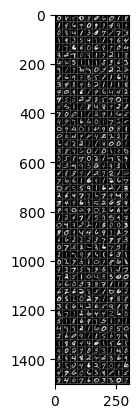

In [7]:
# Folder where the dataset is used
data_set_root = "../data"

# Downloading the mnist (training set)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5],[0.5])])
dataset = datasets.MNIST(data_set_root, train=True, download=True, transform=transform)

# Selecting randomly 500 examples
number_of_examples = 500
rand_perm = torch.randperm(dataset.data.shape[0])[:number_of_examples]
dataset_tensor = torch.cat([dataset.__getitem__(i)[0].reshape(1,-1) for i in rand_perm])

out = torchvision.utils.make_grid(dataset_tensor.reshape(-1, 1, 28, 28), 10, normalize=True, pad_value=0.5)
plt.imshow(out.numpy().transpose(1,2,0))

## Model

In [18]:
from vit import VisionTransformer

image_size = 28
patch_size = 7
in_channels = 1,
num_classes = 10
embed_dim = 64
depth = 6
num_heads = 8
mlp_ratio = 4.0
dropout = 0.1


# Creating the ViT
model = VisionTransformer(
        image_size=image_size,
        patch_size=patch_size,
        in_channels=in_channels,
        num_classes=num_classes,
        embed_dim=embed_dim,
        depth=depth,
        num_heads=num_heads,
        mlp_ratio=mlp_ratio,
        dropout=dropout
    )

TypeError: unsupported operand type(s) for %: 'tuple' and 'int'